# Machine learning analysis of the CRISPR screen data

In this notebook we use a machine learning approach to understand if some sequence features could explain the unexpected fitness defect produced by some guide RNAs.

- **guide**: guide RNA sequence
- **pos**: position in the genome
- **ori**: orientation of the guide with regard to the chromosome
- **gene**: name of gene targeted (if the PAM is within a gene)
- **coding**: orientation with regard to the gene (coding == True means that the guide targets the coding strands, i.e. the non-template strand, which is the orientation giving the strongest repression
- **fit18**: fitness measured in strain LC-E18 (log2FC)
- **fit75**: fitness measured in strain LC-E75 (log2FC)
- **seq**: 60bp surounding the target


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
font = {'size'   : 10}
matplotlib.rc('font', **font)

data=pd.read_csv("screen_data.csv",sep=",")

data.index=data.guide.values
data.head()

guide  gene essential      pos ori  \
AAAAAACCTGCTGGTGAGGC  AAAAAACCTGCTGGTGAGGC   NaN       NaN  2202483   -   
AAAAAACGTATTCGCTTGCA  AAAAAACGTATTCGCTTGCA  curA     False  1517891   +   
AAAAAAGCGCACTTTTTGAC  AAAAAAGCGCACTTTTTGAC   NaN       NaN  1919717   +   
AAAAAAGCGGTGACTTACGA  AAAAAAGCGGTGACTTACGA  bglA     False  3042929   +   
AAAAAATCTGCCCGTGTCGT  AAAAAATCTGCCCGTGTCGT  gyrA      True  2337231   -   

                     coding     fit18     fit75  ntargets  \
AAAAAACCTGCTGGTGAGGC    NaN -4.850012 -1.437546         1   
AAAAAACGTATTCGCTTGCA  False -0.094026 -0.100313         1   
AAAAAAGCGCACTTTTTGAC    NaN -1.109310 -0.246740         1   
AAAAAAGCGGTGACTTACGA  False -1.328831 -0.905068         1   
AAAAAATCTGCCCGTGTCGT  False -0.840373 -0.598858         1   

                                                                    seq  
AAAAAACCTGCTGGTGAGGC  AAAGCAGATCACAGTAAATAAAAAAACCTGCTGGTGAGGCAGGTTC...  
AAAAAACGTATTCGCTTGCA  TGTTGATGGCTACAGTGCTGAAAAAACGTATTCGCTTGCAAGGTTT...  
AAAAAAGCGCACTTTTTGAC  GTAACGCCTGACAGCGCACAAAAAAAGCGCACTTTTTGACTGGCAC...  
AAAAAAGCGGTGACTTACGA  GCGCCCATATCGAAGAGATGAAAAAAGCGGTGACTTACGATGGCGT...  
AAAAAATCTGCCCGTGTCGT  ATGACTGGAACAAAGCCTATAAAAAATCTGCCCGTGTCGTTGGTGA...

In [2]:
data.shape

(85392, 10)

We first fit a regression tree to identify regions where guide RNAs consitently produce a strong fitness defects 

In [2]:
from sklearn.tree import DecisionTreeRegressor

X_ori=(data[["ori"]]=="+").values
X_pos=data[["pos"]].values
Y = data["fit18"].values.astype(np.float32)

reg=DecisionTreeRegressor(criterion='mse', splitter='best', 
                               max_depth=None, min_samples_split=5, 
                               min_samples_leaf=5, min_weight_fraction_leaf=0.0, 
                               max_features=None, random_state=None, max_leaf_nodes=400, presort=False)

#fit on position and ori only
X=np.concatenate((X_ori,X_pos),axis=1)
reg.fit(X,Y)
print(reg.score(X,Y))

0.379007653349


Let's plot the results to see what the regression tree is doing:

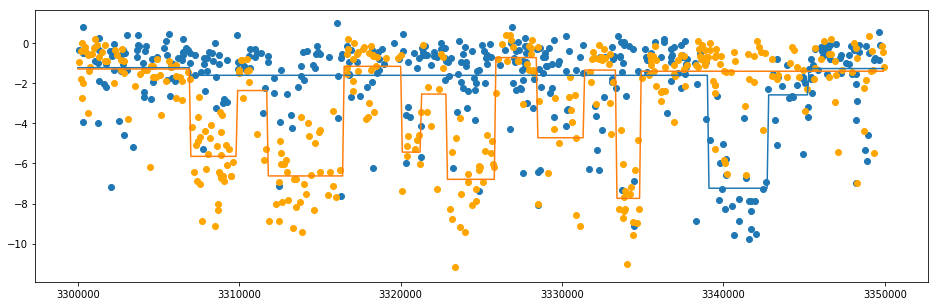

In [3]:
#left, right = 10000, 20000
left, right = (int(3.3e6), int(3.35e6))
fig, ax = plt.subplots(1,1,figsize=(16,5))
Xplus=X_pos[(X_pos>left)*(X_pos<right)*np.logical_not(X_ori).reshape(-1,1)]
Yplus=Y[((X_pos>left)*(X_pos<right)*np.logical_not(X_ori).reshape(-1,1))[:,0]]
ax.scatter(Xplus,Yplus)
r=np.arange(left,right,100)
rplus=np.array([np.zeros(len(r)),r]).T
ax.plot(r,reg.predict(rplus))

Xminus=X_pos[(X_pos>left)*(X_pos<right)*X_ori.reshape(-1,1)]
Yminus=Y[((X_pos>left)*(X_pos<right)*X_ori.reshape(-1,1))[:,0]]
ax.scatter(Xminus,Yminus,c="orange")
r=np.arange(left,right,100)
rplus=np.array([np.ones(len(r)),r]).T
ax.plot(r,reg.predict(rplus))
plt.show()

Adding the results to the dataframe

In [4]:
data["tree_pred18"]=reg.predict(X)[:,np.newaxis]
data.head()

guide  gene essential      pos ori  \
AAAAAACCTGCTGGTGAGGC  AAAAAACCTGCTGGTGAGGC   NaN       NaN  2202483   -   
AAAAAACGTATTCGCTTGCA  AAAAAACGTATTCGCTTGCA  curA     False  1517891   +   
AAAAAAGCGCACTTTTTGAC  AAAAAAGCGCACTTTTTGAC   NaN       NaN  1919717   +   
AAAAAAGCGGTGACTTACGA  AAAAAAGCGGTGACTTACGA  bglA     False  3042929   +   
AAAAAATCTGCCCGTGTCGT  AAAAAATCTGCCCGTGTCGT  gyrA      True  2337231   -   

                     coding     fit18     fit75  ntargets  \
AAAAAACCTGCTGGTGAGGC    NaN -4.850012 -1.437546         1   
AAAAAACGTATTCGCTTGCA  False -0.094026 -0.100313         1   
AAAAAAGCGCACTTTTTGAC    NaN -1.109310 -0.246740         1   
AAAAAAGCGGTGACTTACGA  False -1.328831 -0.905068         1   
AAAAAATCTGCCCGTGTCGT  False -0.840373 -0.598858         1   

                                                                    seq  \
AAAAAACCTGCTGGTGAGGC  AAAGCAGATCACAGTAAATAAAAAAACCTGCTGGTGAGGCAGGTTC...   
AAAAAACGTATTCGCTTGCA  TGTTGATGGCTACAGTGCTGAAAAAACGTATTCGCTTGCAAGGTTT...   
AAAAAAGCGCACTTTTTGAC  GTAACGCCTGACAGCGCACAAAAAAAGCGCACTTTTTGACTGGCAC...   
AAAAAAGCGGTGACTTACGA  GCGCCCATATCGAAGAGATGAAAAAAGCGGTGACTTACGATGGCGT...   
AAAAAATCTGCCCGTGTCGT  ATGACTGGAACAAAGCCTATAAAAAATCTGCCCGTGTCGTTGGTGA...   

                      tree_pred18  
AAAAAACCTGCTGGTGAGGC    -1.198238  
AAAAAACGTATTCGCTTGCA    -1.177359  
AAAAAAGCGCACTTTTTGAC    -1.306040  
AAAAAAGCGGTGACTTACGA    -1.292923  
AAAAAATCTGCCCGTGTCGT    -2.405657

This leaves a lot of guides whose effect on the bacteria fitness remains unexplained. We then train a neural network based on the sequence of these targets in the genome to understand it some features can explain the impact these guides have on *E. coli*. We start by training a neural network using a arbitrary 60b sequence window around the target. Several architechtures (dense, locally connected or convolutional) and hyperparamters were tested and manually tuned to optimize the loss of a validation set. Note that the architechture below gives satisfying performances but could like be further optimized.

In [7]:
#one guide at the very beginning of the genome does not have 60nt of context => remove it.
data2=data[data.ntargets==1]
data2=data2[data2["seq"].str.len()==60]

#Using only data where guides do not have a consistently strong effect
threshold=-3.5
data2=data2[(data2["tree_pred18"]>threshold)]
data2.shape, data.shape, data2[data2.fit18<-3.5].shape

((73705, 11), (85392, 11), (5825, 11))

In [8]:
from sklearn import preprocessing

bases=["A","T","G","C"]
def encode(seq):
    return np.array([[int(b==p) for b in seq] for p in bases])

def encode_seqarr(data,before=20,after=0,dim=1):
    X_seq = np.array([encode(s) for s in data["seq"].str[40-before:40+after].values])
    if dim==1:
        X_seq = X_seq.reshape((X_seq.shape[0],X_seq.shape[1]*X_seq.shape[2]))
        return X_seq
    elif dim==2:
        return X_seq.swapaxes(1,2)


before=40 #number of bases before the PAM 
after=20 #number of bases after the PAM (included)
seqlen=before+after

#one-hot-encoding of the sequence
X_seq = encode_seqarr(data2,before=before,after=after,dim=2) 
print(X_seq.shape)

Y = data2["fit18"].values.reshape(-1,1)
y_scaler = preprocessing.StandardScaler().fit(Y)
Y= y_scaler.transform(Y)

(73705, 60, 4)


In [9]:
#Split the data in training, validation and test sets.
N=len(data2)
permidx=np.random.permutation(N)
trainis=permidx[:int(0.8*N)]
validis=permidx[int(0.8*N):int(0.9*N)]
testis=permidx[int(0.9*N):]
def write_split(trainis,validis,testis,file_name="split.txt"):
    with open(file_name,"w") as handle:
        handle.write("Train set indices:\n")
        handle.write(",".join([str(s) for s in trainis])+"\n")
        handle.write("Validation set indices:\n")
        handle.write(",".join([str(s) for s in validis])+"\n")
        handle.write("Test set indices:\n")
        handle.write(",".join([str(s) for s in testis])+"\n")

#write_split(trainis,validis,testis)
    

In [10]:
#Load split
with open("split.txt") as handle:
    lines=handle.readlines()
    trainis=[int(s) for s in lines[1].strip().split(',')]
    validis=[int(s) for s in lines[3].strip().split(',')]
    testis=[int(s) for s in lines[5].strip().split(',')]

In [11]:
from keras.layers.local import LocallyConnected1D
from keras.layers import merge, Input, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, History
from keras.regularizers import l2
from keras.metrics import MSE
from keras.models import Model
#from keras.utils.visualize_util import plot
import time, os
from keras.layers.convolutional import ZeroPadding1D

def sparseModel(seqlen=20,kernel_size=5,lbd=0):
    input = Input(shape=(seqlen,4))
    sparse=ZeroPadding1D(padding=2)(input)
    sparse=LocallyConnected1D(40, kernel_size, activation="tanh", strides=1, padding="valid", 
                            kernel_initializer="uniform", kernel_regularizer=l2(lbd))(sparse)
    sparse=ZeroPadding1D(padding=2)(sparse)
    sparse=LocallyConnected1D(20, kernel_size, activation="tanh", strides=1, padding="valid", 
                            kernel_initializer="uniform", kernel_regularizer=l2(lbd))(sparse)
    sparse=ZeroPadding1D(padding=2)(sparse)
    sparse=LocallyConnected1D(10, kernel_size, activation="tanh", strides=1, padding="valid", 
                            kernel_initializer="uniform", kernel_regularizer=l2(lbd))(sparse)
    sparse=ZeroPadding1D(padding=2)(sparse)
    sparse=LocallyConnected1D(5, kernel_size, activation="tanh", strides=1, padding="valid", 
                            kernel_initializer="uniform", kernel_regularizer=l2(lbd))(sparse)

    sparse=Flatten()(sparse)
    out = Dense(name="dense_out", units=1, kernel_regularizer=l2(lbd))(sparse)

    model = Model(inputs=input, outputs=out)
    return model

model=sparseModel(seqlen=60, kernel_size=5, lbd=2e-5)
start = time.time()
model.compile(loss="mse", optimizer="adam", metrics=[MSE])
duration = time.time() - start
print("{} s to get compile".format(duration))
model.summary()

Using TensorFlow backend.


0.0762026309967041 s to get compile
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 4)             0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 64, 4)             0         
_________________________________________________________________
locally_connected1d_1 (Local (None, 60, 40)            50400     
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 64, 40)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 60, 20)            241200    
_________________________________________________________________
zero_padding1d_3 (ZeroPaddin (None, 64, 20)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 60, 

In [12]:
#filepath="tmp/weights.hdf5"
stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=2, mode='auto')

#print X_seq2.shape, X_treepred.shape, Y.shape
model.fit(X_seq[trainis], Y[trainis], 
          epochs=100, batch_size=32, 
          validation_data=[X_seq[validis], Y[validis]], verbose=2, callbacks=[stopping])

Train on 58935 samples, validate on 7367 samples
Epoch 1/100
 - 118s - loss: 0.9471 - mean_squared_error: 0.9438 - val_loss: 0.9431 - val_mean_squared_error: 0.9410
Epoch 2/100
 - 109s - loss: 0.9312 - mean_squared_error: 0.9289 - val_loss: 0.9420 - val_mean_squared_error: 0.9392
Epoch 3/100
 - 107s - loss: 0.8946 - mean_squared_error: 0.8905 - val_loss: 0.8788 - val_mean_squared_error: 0.8727
Epoch 4/100
 - 105s - loss: 0.8535 - mean_squared_error: 0.8469 - val_loss: 0.8414 - val_mean_squared_error: 0.8340
Epoch 5/100
 - 106s - loss: 0.8283 - mean_squared_error: 0.8202 - val_loss: 0.8354 - val_mean_squared_error: 0.8265
Epoch 6/100
 - 108s - loss: 0.8006 - mean_squared_error: 0.7905 - val_loss: 0.8046 - val_mean_squared_error: 0.7927
Epoch 7/100
 - 105s - loss: 0.7784 - mean_squared_error: 0.7661 - val_loss: 0.7805 - val_mean_squared_error: 0.7673
Epoch 8/100
 - 117s - loss: 0.7606 - mean_squared_error: 0.7470 - val_loss: 0.7880 - val_mean_squared_error: 0.7738
Epoch 00008: early stop

In [13]:
#Pearson R
from scipy.stats import pearsonr, spearmanr
print("pearson-r {:.2}".format(pearsonr(model.predict(X_seq[testis]),Y[testis])[0][0]))
print("spearman-r {:.2}".format(spearmanr(model.predict(X_seq[testis]),Y[testis]).correlation))

pearson-r 0.51
spearman-r 0.53


To understand what information the model used to make predictions we performe in silico experiments. We generate a set of 1000 random sequences and measured the effect on the model prediction of mutating each position along the sequence. This reveals that the model uses the whole 20nt of the guide sequence, and in particular the 5 PAM-proximal bases, but not the surrounding region to make its predictions 

In [14]:
from random import choice
def encode_list(seqList):
    X_seq=np.array([encode(x) for x in seqList])
    X_seq=X_seq.swapaxes(1,2)
    #X_seq = X_seq.reshape((X_seq.shape[0],X_seq.shape[1]*X_seq.shape[2]))
    return X_seq

seqlen=60
N=100
randomset=[]
for i in range(N):
    randomset.append([choice(bases) for i in range(seqlen)])

randomset = np.array(randomset)
def mutationEffects(randomset,model):
    randomset_=encode_list(randomset)
    print(randomset_.shape)
    df_pred=y_scaler.inverse_transform(model.predict(randomset_)) #Computes predictions for the random set

    repdic=dict([(b,np.repeat(b,N)) for b in bases])
    rec=dict([(b1,dict([(b2,[]) for b2 in bases if b2!=b1])) for b1 in bases])
    for i in range(seqlen):
        for j,b1 in enumerate(bases):
            b1_idx=np.where(randomset[:,i]==repdic[b1])
            randomset_mut=randomset[b1_idx] #selects sequences in the set that have b1 at position i
            for k,b2 in enumerate(bases):
                if b2!=b1: #mutate to all different bases
                    randomset_mut[:,i]=repdic[b2][b1_idx]
                    randomset_mut_=encode_list(randomset_mut)
                    Ei=y_scaler.inverse_transform(model.predict(randomset_mut_))-df_pred[b1_idx]
                    rec[b1][b2].append(Ei) #record effect of mutations
    
    return rec
rec=mutationEffects(randomset,model)

(100, 60, 4)


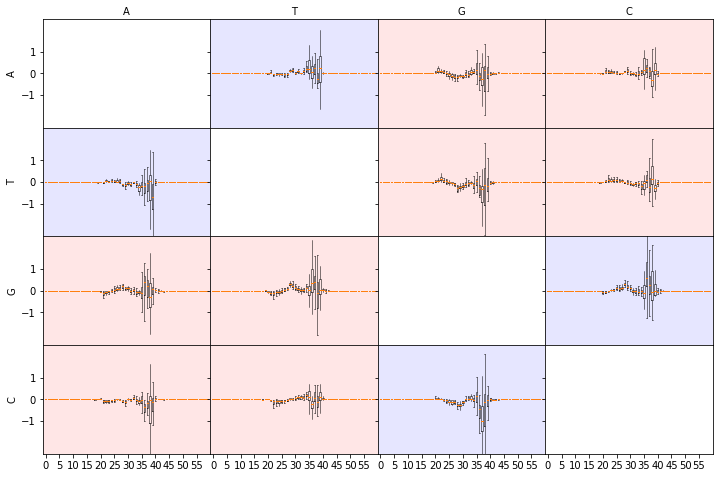

In [15]:
def plt_Ei(rec,save_path=""):
    fig, axes=plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(12,8))
    for i, axlist in enumerate(axes):
        for j, ax in enumerate(axlist):
            if i==0:
                ax.set_xlabel("%s" % (bases[j]))
                ax.xaxis.set_label_position('top') 
            if j==0:
                ax.set_ylabel("%s" % (bases[i]))

            if i!=j:
                if (bases[i] in ["A","T"] and bases[j] in ["A","T"]) or (bases[i] in ["C","G"] and bases[j] in ["C","G"]):
                    #highlight transitions vs transversion
                    ax.set_facecolor((0.9,0.9,1))#RGB tuple
                else:
                    ax.set_facecolor((1,0.9,0.9))#RGB tuple

                box_parts = ax.boxplot(rec[bases[i]][bases[j]],  0, '')
                for pc in box_parts["whiskers"]:
                    pc.set_linestyle("solid")
                    pc.set_linewidth(0.5)
                for pc in box_parts["boxes"]:
                    pc.set_linewidth(0.5)
                for pc in box_parts["caps"]:
                    pc.set_linewidth(0.5)
                for pc in box_parts["means"]:
                    pc.set_linewidth(0.5)


                ax.set_xlim(0,seqlen+1)
                ax.set_xticks(range(1,seqlen+1,5))
                ax.set_xticklabels(map(str, range(0,seqlen+1,5)))
                ax.set_ylim((-2.5,2.5))
                ax.set_yticks(np.arange(-1,2,1))
            #ax.set_yticklabels(map(str,np.arange(0.95,1.0,0.05)))

    #print(box_parts.keys())
    fig.subplots_adjust(hspace=0,wspace=0)
    if save_path:
        fig.savefig(save_path)#, format='eps')
    plt.show()

plt_Ei(rec,save_path=None)

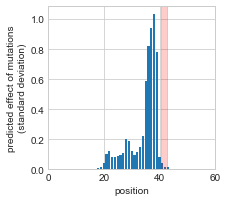

In [16]:
#Plot just the standard deviation of all Ei for each position.
import seaborn as sns
sns.set_style("whitegrid")
Ei_stdev=[]
for i in range(60):
    Ei_concat=np.concatenate([np.concatenate([rec[b1][b2][i] for b2 in bases if b1!=b2]) for b1 in bases])
    Ei_stdev.append(np.std(Ei_concat))

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.bar(range(60),Ei_stdev,width=0.8)
ax.axvspan(40.5,42.5,color="red",alpha=0.2)
ax.set_xlim(0,60)
ax.set_xlabel("position")
ax.set_ylabel("predicted effect of mutations\n(standard deviation)")

#plt.savefig("figures/Ei_stdev_60bp.eps",format="eps")
plt.show()

Only the guide sequence seems to matter for the prediction. We thus train again using just the 20nt of the guide sequence.

In [17]:
before=20 #number of bases before the PAM 
after=0 #number of bases after the PAM (included)
seqlen=before+after
#encode features
X_seq2 = encode_seqarr(data2,before=20,after=0,dim=2)

print(X_seq2.shape)

model2=sparseModel(seqlen=20,kernel_size=5,lbd=2e-5)
start = time.time()
model2.compile(loss="mse", optimizer="adam", metrics=[MSE])
duration = time.time() - start
print("{} s to get compile".format(duration))

#filepath="tmp/weights.hdf5"
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

model2.fit(X_seq2[trainis], Y[trainis], 
          epochs=100, batch_size=32, 
          validation_data=[X_seq2[validis], Y[validis]], verbose=2, callbacks=[stopping])

(73705, 20, 4)
0.06240034103393555 s to get compile
Train on 58935 samples, validate on 7367 samples
Epoch 1/100
 - 33s - loss: 0.9468 - mean_squared_error: 0.9449 - val_loss: 0.9461 - val_mean_squared_error: 0.9444
Epoch 2/100
 - 30s - loss: 0.9365 - mean_squared_error: 0.9349 - val_loss: 0.9412 - val_mean_squared_error: 0.9394
Epoch 3/100
 - 29s - loss: 0.9226 - mean_squared_error: 0.9204 - val_loss: 0.9095 - val_mean_squared_error: 0.9066
Epoch 4/100
 - 29s - loss: 0.8878 - mean_squared_error: 0.8840 - val_loss: 0.8738 - val_mean_squared_error: 0.8695
Epoch 5/100
 - 30s - loss: 0.8655 - mean_squared_error: 0.8605 - val_loss: 0.8585 - val_mean_squared_error: 0.8529
Epoch 6/100
 - 29s - loss: 0.8457 - mean_squared_error: 0.8393 - val_loss: 0.8482 - val_mean_squared_error: 0.8411
Epoch 7/100
 - 29s - loss: 0.8216 - mean_squared_error: 0.8135 - val_loss: 0.8142 - val_mean_squared_error: 0.8051
Epoch 8/100
 - 29s - loss: 0.7925 - mean_squared_error: 0.7825 - val_loss: 0.7956 - val_mean_s

pearson-r 0.56
spearman-r 0.53


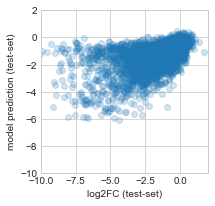

In [19]:
print("pearson-r {:.2}".format(pearsonr(model2.predict(X_seq2[testis]),Y[testis])[0][0]))
print("spearman-r {:.2}".format(spearmanr(model.predict(X_seq[testis]),Y[testis]).correlation))
fig, ax=plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_scaler.inverse_transform(Y[testis]),y_scaler.inverse_transform(model2.predict(X_seq2[testis])),alpha=0.2)
ax.set_xlim(-10,2)
ax.set_xlabel("log2FC (test-set)")
ax.set_ylim(-10,2)
ax.set_ylabel("model prediction (test-set)")
plt.show()

(1000, 20, 4)


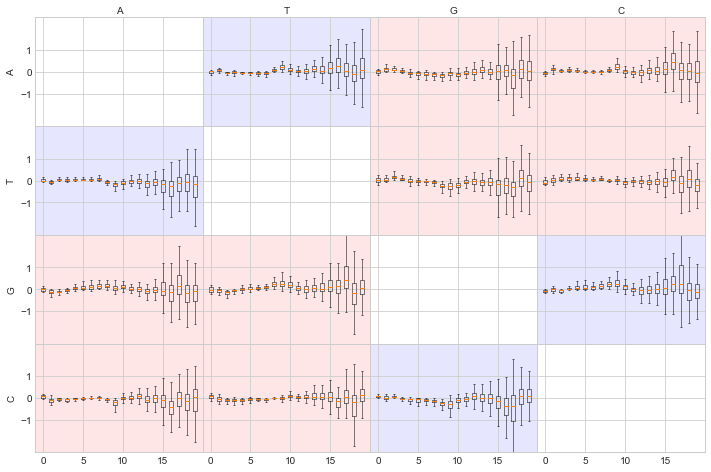

In [20]:
from random import choice
seqlen=20
randomset=[]
N=1000
for i in range(N):
    randomset.append([choice(bases) for i in range(seqlen)])

randomset = np.array(randomset)
rec=mutationEffects(randomset,model=model2)
plt_Ei(rec,save_path=None)

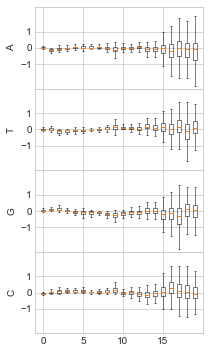

In [25]:
fig, axes=plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True,figsize=(3,6))
for i, ax in enumerate(axes):
    box_parts = ax.boxplot([np.concatenate([rec[b][bases[i]][p] for b in bases if b!=bases[i]]) for p in range(seqlen)],  0, '')
    for pc in box_parts["whiskers"]:
        pc.set_linestyle("solid")
        pc.set_linewidth(0.5)
    for pc in box_parts["boxes"]:
        pc.set_linewidth(0.5)
    for pc in box_parts["caps"]:
        pc.set_linewidth(0.5)
    for pc in box_parts["means"]:
        pc.set_linewidth(0.5)
    
    ax.set_ylabel("%s" % (bases[i]))
    ax.set_xlim(0,seqlen+1)
    ax.set_xticks(range(1,seqlen+1,5))
    ax.set_xticklabels(map(str, range(0,seqlen+1,5)))
    ax.set_ylim((-2.5,2.5))
    ax.set_yticks(np.arange(-1,2,1))
    #ax.set_yticklabels(map(str,np.arange(0.95,1.0,0.05)))
    
#plt.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/mutation_effect_20.eps', format='eps')
plt.show()

When doing this in silico mutational analysis one can also see that the effect of individual mutations depends a lot on the sequence context (Fig. 3b and Supplementary Fig. 4). For instance, a mutation at position 18 to a G can have a positive or a negative impact on the fitness depending on the rest of the sequence. This suggests important interactions between bases. To analyze these interactions, we mutated in silico every pair of bases and compared the effect of individual mutations to that of pairs of mutations. An interaction is observed if the effect of a pair of mutation is not simply the sum of the effects of individual mutations 

In [26]:
from random import choice
from IPython import display
randomset=[]
N=20
for i in range(N):
    randomset.append([choice(bases) for i in range(seqlen)])

randomset = np.array(randomset)
randomset_ = encode_list(randomset)

df_pred=model2.predict(randomset_)

repdic={"A":np.repeat("A",N),
        "T":np.repeat("T",N),
        "G":np.repeat("G",N),
        "C":np.repeat("C",N)}

rec=dict([(i,dict([(j,dict([("Ei",[]),("Ej",[]),("Eij",[])])) for j in range(seqlen)])) for i in range(seqlen)])
rec2_av=dict([(b1,dict([(b2,[]) for b2 in bases])) for b1 in bases])

for i in range(seqlen):
    display.clear_output(wait=True)
    print(i)
    for j in range(i,seqlen):
        for b1 in bases:
            for b2 in bases:
                Bidx=np.where(np.all([randomset[:,i]!=repdic[b1],randomset[:,j]!=repdic[b2]],axis=0))[0]
                #mutation at position i
                randomset_muti=randomset[Bidx]
                randomset_muti[:,i]=repdic[b1][Bidx]
                randomset_muti_=encode_list(randomset_muti)
                Ei=model2.predict(randomset_muti_)-df_pred[Bidx]
                
                #mutation at position j
                randomset_mutj=randomset[Bidx]
                randomset_mutj[:,j]=repdic[b2][Bidx]
                randomset_mutj_=encode_list(randomset_mutj)
                Ej=model2.predict(randomset_mutj_)-df_pred[Bidx]
                
                #double mutation
                randomset_mutij=randomset[Bidx]
                randomset_mutij[:,i]=repdic[b1][Bidx]
                randomset_mutij[:,j]=repdic[b2][Bidx]
                randomset_mutij_=encode_list(randomset_mutij)
                Eij=model2.predict(randomset_mutij_)-df_pred[Bidx]
                
                rec2_av[b1][b2].append(np.mean(np.square(Eij-(Ei+Ej)))) #distance between the effect of simple and double mutations
                rec[i][j]["Ei"]+=list(Ei)
                rec[i][j]["Ej"]+=list(Ej)
                rec[i][j]["Eij"]+=list(Eij)

19


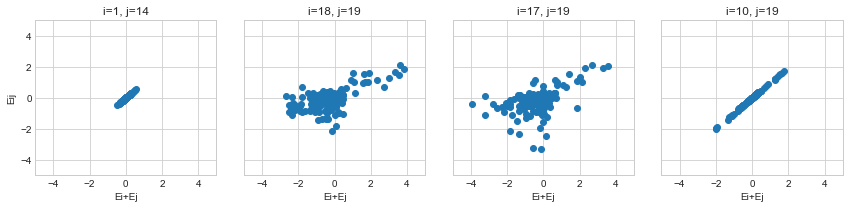

In [29]:
pairs=[(1,14),(18,19),(17,19),(10,19)]
fig, axes = plt.subplots(1,len(pairs),figsize=(len(pairs)*3,3),sharey=True)

for p, (i,j) in enumerate(pairs):
    Ei=np.array(rec[i][j]["Ei"])
    Ej=np.array(rec[i][j]["Ej"])
    Eij=np.array(rec[i][j]["Eij"])
    axes[p].scatter(Ei+Ej,Eij)
    axes[p].set_xlim(-5,5)
    axes[p].set_ylim(-5,5)
    axes[p].set_title("i=%i, j=%i" % (i,j))
    axes[p].set_xlabel("Ei+Ej")
axes[0].set_ylabel("Eij")

plt.tight_layout()
#fig.savefig('figures/interaction_examples.eps', format='eps')
plt.show()

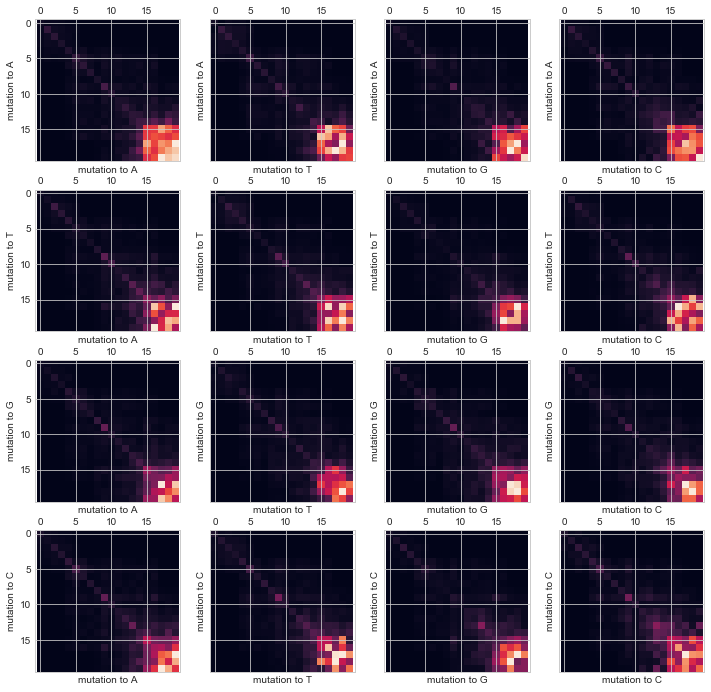

In [30]:
interaction={"A":{"A":[],"T":[],"G":[],"C":[]},
     "T":{"A":[],"T":[],"G":[],"C":[]},
     "G":{"A":[],"T":[],"G":[],"C":[]},
     "C":{"A":[],"T":[],"G":[],"C":[]}}
fig, axes = plt.subplots(4,4,figsize=(12,12),sharex=True, sharey=True)
for idx1,b1 in enumerate(bases):
    for idx2,b2 in enumerate(bases):
        #print b1,b2
        av=np.array(rec2_av[b1][b2])
        avreshaped=np.zeros((seqlen,seqlen))
        p=0
        for i in range(seqlen):
            avreshaped[i,i:]=av[p:p+seqlen-i]
            p+=seqlen-i
        
        interaction[b1][b2]=avreshaped       
        axes[idx1,idx2].matshow(np.power(avreshaped+avreshaped.T,0.5))
        axes[idx1,idx2].set_ylabel("mutation to %s" % (b1))
        axes[idx1,idx2].set_xlabel("mutation to %s" % (b2))

#fig.savefig("figures/interaction16x16.png")
plt.show()

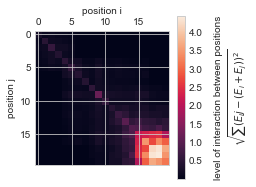

In [31]:
#Sum the interaction of all the 16 plots above
intersum=np.array([np.array(list(x.values())).sum(axis=0) for x in list(interaction.values())]).sum(axis=0)

fig, ax = plt.subplots(1,1,figsize=(3,3))
cax = ax.matshow(np.power(intersum+intersum.T,0.5))
cb=fig.colorbar(cax)
cb.set_label("\nlevel of interaction between positions\n"+r'$\sqrt{\sum (E_ij-(E_i+E_j))^2}$')
ax.set_xlabel("position i")
ax.xaxis.set_label_position('top') 
ax.set_ylabel("position j")

#fig.savefig('figures/interaction_plot_kernel5.eps', format='eps')
plt.show()

#plt.matshow(intersum+intersum.T)
#plt.show()

The effect of individual bases and positions in the guide sequence appeared to strongly depend on the sequence context (Fig. 2b). In particular a strong network of interaction between the 5 bases of the seed could be detected (Fig. 2c and Supplementary Fig. 4). We observed that the distributions of fitness effects produced by guides with any given 5 bases seed sequence are remarkably narrow. For instance, all guides with an ACCCA seed sequence produce a strong fitness defect regardless of their target position, while all guides with an ATACT seed sequence produce an intermediate fitness defect (Fig. 3a). 

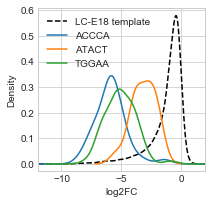

In [32]:
fig, ax= plt.subplots(1,1,figsize=(3,3))
data2.loc[data2.coding==False,"fit18"].plot.kde(ax=ax,style="k--",label="LC-E18 template")
data2.loc[data2["guide"].str[-5:]=="ACCCA","fit18"].plot.kde(ax=ax,label="ACCCA")
data2.loc[data2["guide"].str[-5:]=="ATACT","fit18"].plot.kde(ax=ax,label="ATACT")
data2.loc[data2["guide"].str[-5:]=="TGGAA","fit18"].plot.kde(ax=ax,label="TGGAA")

ax.set_xlim(-12,2)
ax.set_xlabel("log2FC")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc=0)
#fig.savefig("figures/example_badseed_distribution.eps",format="eps")
plt.show()

All in all 132 out of the 1024 possible combinations of 5 nucleotides show a significantly reduced fitness compared to the mean (single sample t-test, p <0.01 after Bonferroni correction). 

In [7]:
seeds_df=data2[["fit18","fit75"]].groupby(data2["guide"].str[-5:]).agg([np.mean, np.std, len])
seeds_df=seeds_df.sort_values([("fit18","mean")])
seeds_df.head(10)

fit18                     fit75                
           mean       std   len      mean       std   len
guide                                                    
AGGAA -6.502737  1.065391  39.0 -2.978649  0.923723  39.0
TGACT -5.895691  1.075286  23.0 -1.339866  0.815282  23.0
ACCCA -5.865223  1.286947  38.0 -2.456791  1.075878  38.0
AAAGG -5.631256  1.069102  41.0 -1.684160  0.579013  41.0
GAGGC -5.405640  1.103803  33.0 -1.906550  1.175584  33.0
CGGAA -5.396716  1.274452  72.0 -1.513664  1.240732  72.0
ATATG -5.367744  1.418214  50.0 -1.077234  0.622017  50.0
AACTA -5.104423  1.539860  24.0 -0.884380  1.635388  24.0
TGGAA -5.069583  1.243113  66.0 -1.257992  1.014724  66.0
CACTC -5.005689  1.237323  64.0 -1.763704  1.482857  64.0

In [8]:
import crUtils
len(crUtils.off_targets(seeds_df.index[0],5))

loading off-targets with seed of size 5 in cache...


444

In [9]:
seeds_df["noff"]=[len(crUtils.off_targets(x,5)) for x in seeds_df.index]

In [10]:
seeds_df.head()

fit18                     fit75                 noff
           mean       std   len      mean       std   len     
guide                                                         
AGGAA -6.502737  1.065391  39.0 -2.978649  0.923723  39.0  444
TGACT -5.895691  1.075286  23.0 -1.339866  0.815282  23.0  190
ACCCA -5.865223  1.286947  38.0 -2.456791  1.075878  38.0  311
AAAGG -5.631256  1.069102  41.0 -1.684160  0.579013  41.0  517
GAGGC -5.405640  1.103803  33.0 -1.906550  1.175584  33.0  283

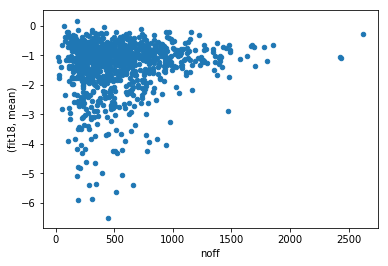

In [12]:
fig,ax=plt.subplots(1,1)
seeds_df.plot.scatter(x="noff",y=("fit18","mean"),ax=ax)
plt.show()
fig.savefig("figures/badseed_noff.eps",format="eps")

In [35]:
from scipy.stats import ttest_1samp
from statsmodels.sandbox.stats.multicomp import multipletests
E18mean=np.mean(data2["fit18"].values)
E75mean=np.mean(data2["fit75"].values)
for p in seeds_df.index:
    d=data2[data2["seq"].str[35:40]==p][["fit18","fit75"]]
    pval18=ttest_1samp(d["fit18"].values, E18mean).pvalue
    pval75=ttest_1samp(d["fit75"].values, E75mean).pvalue
    seeds_df.loc[p,("fit18","pval")]=pval18
    seeds_df.loc[p,("fit75","pval")]=pval75
    #dataseed.loc[dataseed["seq"]==p,"E75pval"]=pval75
 

#Correction for multiple hypothesis testing
from statsmodels.sandbox.stats.multicomp import multipletests
seeds_df[("fit18","pval.adj")]=multipletests(seeds_df[[("fit18","pval")]].values.squeeze(),method="bonferroni")[1]
seeds_df[("fit75","pval.adj")]=multipletests(seeds_df[[("fit75","pval")]].values.squeeze(),method="bonferroni")[1]

seeds_df=seeds_df.sort_index(axis=1)

In [36]:
seeds_df=seeds_df.sort_values([("fit18","mean")])
mask=(seeds_df[("fit18","mean")]<E18mean) & (seeds_df[("fit18","pval.adj")]<0.01)
badseeds18=seeds_df[mask].index.values
print(seeds_df[mask].head(10))
len(badseeds18)

      fit18                                                 fit75            \
        len      mean          pval      pval.adj       std   len      mean   
guide                                                                         
AGGAA  39.0 -6.502737  1.662049e-28  1.698614e-25  1.065391  39.0 -2.978649   
TGACT  23.0 -5.895691  6.087593e-16  6.221520e-13  1.075286  23.0 -1.339866   
ACCCA  38.0 -5.865223  5.985858e-23  6.117546e-20  1.286947  38.0 -2.456791   
AAAGG  41.0 -5.631256  7.347240e-27  7.508880e-24  1.069102  41.0 -1.684160   
GAGGC  33.0 -5.405640  1.076898e-20  1.100589e-17  1.103803  33.0 -1.906550   
CGGAA  72.0 -5.396716  9.145040e-40  9.346231e-37  1.274452  72.0 -1.513664   
ATATG  50.0 -5.367744  9.234329e-26  9.437484e-23  1.418214  50.0 -1.077234   
AACTA  24.0 -5.104423  1.363922e-11  1.393929e-08  1.539860  24.0 -0.884380   
TGGAA  66.0 -5.069583  4.437957e-35  4.535592e-32  1.243113  66.0 -1.257992   
CACTC  64.0 -5.005689  9.465794e-34  9.674042e-31  1

130

Strain LC-E75 carrying this fine-tuned Ptet-dCas9 cassette was then used to perform a genome-wide dCas9 knockdown screen following the same protocol as the screen previously performed with strain LC-E18. As expected, many guides which produced a strong fitness defect in strain LC-E18 had a weaker or no effect in strain LC-E75, but targets in the coding strand of essential genes still produced a strong fitness defect (Fig 3c and Supplementary Fig. 8). When plotting the fitness effect of guides sharing a given seed sequence, one can see that the “bad seed” effect is largely alleviated in strain LC-E75, but not abolished (Fig. 3d,e). 

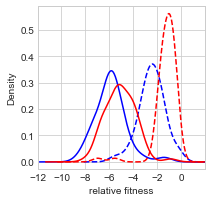

In [37]:
fig =plt.figure(figsize=(3,3))
ax= data2[data2["seq"].str[35:40]=="ACCCA"]["fit18"].plot.kde(color="blue")
data2[data2["seq"].str[35:40]=="ACCCA"]["fit75"].plot.kde(ax=ax,style='b--')
data2[data2["seq"].str[35:40]=="TGGAA"]["fit18"].plot.kde(ax=ax,color="r")
data2[data2["seq"].str[35:40]=="TGGAA"]["fit75"].plot.kde(ax=ax,style='r--')

ax.set_xlim(-12,2)
ax.set_xticks(np.arange(-12,2,2))
ax.set_xlabel("relative fitness")
#fig.savefig('figures/badseed_LC18_LC75_comp.eps', format='eps')
plt.show()

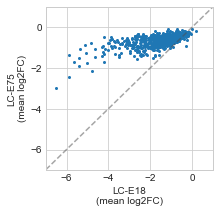

In [38]:
from matplotlib import colors
from adjustText import adjust_text
sig_filt=((seeds_df[("fit75","mean")]<-0.5) & (seeds_df[("fit75","pval.adj")]<0.01))
fig, ax= plt.subplots(1,1,figsize=(3,3))
ax.scatter(seeds_df["fit18","mean"],seeds_df["fit75","mean"], s=4,
           #s=seeds_df["fit18","len"],
           #c=[int(x) for x in sig_filt.values],
           #cmap=colors.ListedColormap(["blue","red"]),
           #alpha=0.2
          )
ax.plot([-10, 2], [-10, 2], ls="--", c=".3", alpha=0.5)
ax.set_xlim(-7,1)
ax.set_xticks(np.arange(-6,1,2))
ax.set_xlabel("LC-E18\n(mean log2FC)")
ax.set_ylim(-7,1)
ax.set_yticks(np.arange(-6,1,2))
ax.set_ylabel("LC-E75\n(mean log2FC)")

#texts=[]
#for idx, s in seeds_df[sig_filt].iterrows():
#    texts.append(ax.text(s["fit18","mean"]+0.5, s["fit75","mean"]-0.2, idx, size=10))

#adjust_text(texts, autoalign='y',
#                only_move={'points': 'y', 'text': 'y'})  # , arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

#fig.savefig("figures/bad_seed_comparision.eps",format="eps")
plt.show()

Only 14 seed sequences still produced a moderate or weak significant effect (Supplementary Table 1). 

In [41]:
seeds_df=seeds_df.sort_values([("fit75","mean")])
mask=(seeds_df[("fit75","mean")]<E75mean) & (seeds_df[("fit75","pval.adj")]<0.01)
badseeds75=seeds_df[mask].index.values
print(seeds_df[mask])
len(badseeds75)

       fit18                                                  fit75            \
         len      mean          pval      pval.adj       std    len      mean   
guide                                                                           
AGGAA   39.0 -6.502737  1.662049e-28  1.698614e-25  1.065391   39.0 -2.978649   
ACCCA   38.0 -5.865223  5.985858e-23  6.117546e-20  1.286947   38.0 -2.456791   
TATAG   18.0 -4.783538  6.365394e-09  6.505433e-06  1.415420   18.0 -2.124153   
GAGGC   33.0 -5.405640  1.076898e-20  1.100589e-17  1.103803   33.0 -1.906550   
CACTC   64.0 -5.005689  9.465794e-34  9.674042e-31  1.237323   64.0 -1.763704   
AAAGG   41.0 -5.631256  7.347240e-27  7.508880e-24  1.069102   41.0 -1.684160   
CGGAA   72.0 -5.396716  9.145040e-40  9.346231e-37  1.274452   72.0 -1.513664   
CAACC  123.0 -2.508367  1.649599e-11  1.685890e-08  1.892817  123.0 -1.346960   
ATTAA   79.0 -4.231255  2.842212e-35  2.904741e-32  1.204809   79.0 -1.299693   
TGGAA   66.0 -5.069583  4.43

14

We can estimate that the bad seed effect accounted for the fitness defect produced by ~37% of the guides with an unexpected strong fitness, while this proportion drops to ~3% in the new screen performed in strain LCE-75

In [42]:
flt=(data["essential"]==False) & (data["coding"]==False)
badseeds18=seeds_df[(seeds_df[("fit18","mean")]<E18mean) & (seeds_df[("fit18","pval.adj")]<0.01)].index.values

contigency=pd.crosstab(data[flt].guide.str[-5:].isin(badseeds18),data[flt].fit18<threshold,margins=True)
print(contigency)
contigencyF=contigency/np.array([contigency.loc["All"].values]*3)
print(contigencyF)

falsePos, truePos=contigencyF.values[1,:2]
print("\nEstimatation of the proportion of guides producing an unexpectedly \
strong fitness defect that can be explained by a bad seed: {0:.0%} ({1:4.0f} guides)".format(truePos-falsePos,(truePos-falsePos)*contigency.values[2,1]))

import scipy.stats as stats
print("\nFisher exact test p-value: {:.4}".format(stats.fisher_exact(contigency.values[:2,:2])[1]))

fit18  False  True    All
guide                    
False  33968  1553  35521
True    3509  1316   4825
All    37477  2869  40346
fit18     False      True       All
guide                              
False  0.906369  0.541304  0.880409
True   0.093631  0.458696  0.119591
All    1.000000  1.000000  1.000000

Estimatation of the proportion of guides producing an unexpectedly strong fitness defect that can be explained by a bad seed: 37% (1047 guides)

Fisher exact test p-value: 0.0


In [43]:
flt=(data["essential"]==False) & (data["coding"]==False)
badseeds75=seeds_df[(seeds_df[("fit75","mean")]<E75mean) & (seeds_df[("fit75","pval.adj")]<0.01)].index.values

contigency=pd.crosstab(data[flt].guide.str[-5:].isin(badseeds75),data[flt].fit75<threshold,margins=True)
print(contigency)
contigencyF=contigency/np.array([contigency.loc["All"].values]*3)
print(contigencyF)

falsePos, truePos=contigencyF.values[1,:2]
print("\nEstimatation of the proportion of guides producing an unexpectedly \
strong fitness defect that can be explained by a bad seed: {0:.0%} ({1:4.0f} guides)".format(truePos-falsePos,(truePos-falsePos)*contigency.values[2,1]))

import scipy.stats as stats
print("\nFisher exact test p-value: {:.4}".format(stats.fisher_exact(contigency.values[:2,:2])[1]))


fit75  False  True    All
guide                    
False  39245   605  39850
True     472    24    496
All    39717   629  40346
fit75     False      True       All
guide                              
False  0.988116  0.961844  0.987706
True   0.011884  0.038156  0.012294
All    1.000000  1.000000  1.000000

Estimatation of the proportion of guides producing an unexpectedly strong fitness defect that can be explained by a bad seed: 3% (  17 guides)

Fisher exact test p-value: 1.321e-06


This new dCas9 expression cassette also makes the general quality of the screen better as the effect of targets within the same gene is now much more consistent (compare Fig. 3f and Fig. 1c; Supplementary Fig. 9)

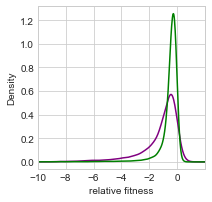

In [44]:
fig, ax1 =plt.subplots(1,1,figsize=(3,3))
data[(data["coding"]==False)]["fit18"].plot.kde(ax=ax1,color="purple")
data[(data["coding"]==False)]["fit75"].plot.kde(ax=ax1,color="green")
ax1.set_xlim(-10,2)
ax1.set_xticks(np.arange(-10,2,2))
ax1.set_xlabel("relative fitness")

#fig.savefig('figures/density plot of E18 vs E75 template only.eps', format='eps')
plt.show()